In [1]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
#from lib import RadioUNet_modules3, RadioUNet_loaders2
from lib import loaders, modules

## Dataset Loader
In this section, we load the RadioMapSeer dataset, which contains urban layout maps and corresponding simulated radio maps. The dataset includes 700 maps, each with multiple transmitter locations and their corresponding pathloss maps generated via simulations using the Dominant Path Model (DPM). The layout is a 256x256 grayscale image, and the radio maps are used to train the model to estimate pathloss.

In [5]:


Radio_train = loaders.RadioUNet_c(phase="train")
Radio_val = loaders.RadioUNet_c(phase="val")
Radio_test = loaders.RadioUNet_c(phase="test")

image_datasets = {
    'train': Radio_train, 'val': Radio_val
}

batch_size = 15

dataloaders = {
    'train': DataLoader(Radio_train, batch_size=batch_size, shuffle=True, num_workers=1),
    'val': DataLoader(Radio_val, batch_size=batch_size, shuffle=True, num_workers=1)
}


## Test Sample Image
This portion of the code visualizes sample input images from the dataset. We display both the layout and the corresponding radio map (pathloss map) that the model will use for training and validation. These images help us understand the structure of the dataset, showing how the layout and pathloss map are represented.

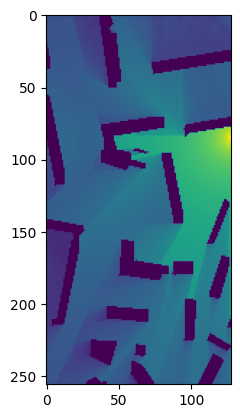

In [6]:
i=1000
image_build_ant, image_gain = Radio_train[i]
plt.imshow(image_gain[0])

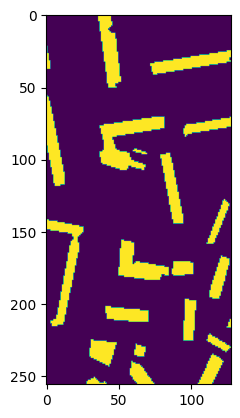

In [7]:
plt.imshow(image_build_ant[0])

## Load Model and Summary
Here, we define and load the BoundaryUNet model, which is based on the UNet architecture. The BoundaryUNet takes the layout and boundary pathloss vectors as inputs and outputs the predicted pathloss map. This section also includes a model summary, which shows the number of layers, the type of layers, and the number of parameters for each part of the network.

In [15]:
from torchsummary import summary

torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.enabled
model =modules.RadioWNet(phase="secondU")
# model.cuda()
summary(model, input_size=(2, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 128, 256]             114
              ReLU-2          [-1, 6, 128, 256]               0
         MaxPool2d-3          [-1, 6, 128, 256]               0
            Conv2d-4         [-1, 40, 128, 256]           6,040
              ReLU-5         [-1, 40, 128, 256]               0
         MaxPool2d-6          [-1, 40, 64, 128]               0
            Conv2d-7          [-1, 50, 64, 128]          50,050
              ReLU-8          [-1, 50, 64, 128]               0
         MaxPool2d-9           [-1, 50, 32, 64]               0
           Conv2d-10           [-1, 60, 32, 64]          75,060
             ReLU-11           [-1, 60, 32, 64]               0
        MaxPool2d-12           [-1, 60, 32, 64]               0
           Conv2d-13          [-1, 100, 32, 64]         150,100
             ReLU-14          [-1, 100,

## Training Loop
This section covers the model training process. We use the Adam optimizer and Mean Squared Error (MSE) loss function to optimize the network. The training loop iterates through the dataset, computing the loss between the predicted pathloss and the ground truth, updating the weights of the network accordingly. Training progress is logged and performance metrics are recorded.

In [9]:
#Adapted from https://github.com/usuyama/pytorch-unet

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn

def calc_loss_dense(pred, target, metrics):
    criterion = nn.MSELoss()
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def calc_loss_sparse(pred, target, samples, metrics, num_samples):
    criterion = nn.MSELoss()
    loss = criterion(samples*pred, samples*target)*(256**2)/num_samples
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs1 = []
    outputs2 = []
    for k in metrics.keys():
        outputs1.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs1)))

def train_model(model, optimizer, scheduler, num_epochs=50, WNetPhase="firstU", targetType="dense", num_samples=300):
    # WNetPhase: traine first U and freez second ("firstU"), or vice verse ("secondU").
    # targetType: train against dense images ("dense") or sparse measurements ("sparse")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("learning rate", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            if targetType=="dense":
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1,outputs2] = model(inputs)
                        if WNetPhase=="firstU":
                            loss = calc_loss_dense(outputs1, targets, metrics)
                        else:
                            loss = calc_loss_dense(outputs2, targets, metrics)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)
            elif targetType=="sparse":
                for inputs, targets, samples in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    samples = samples.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1,outputs2] = model(inputs)
                        if WNetPhase=="firstU":
                            loss = calc_loss_sparse(outputs1, targets, samples, metrics, num_samples)
                        else:
                            loss = calc_loss_sparse(outputs2, targets, samples, metrics, num_samples)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training First UNet
The first UNet in the BoundaryUNet model processes the input layout map and produces an intermediate feature representation. This part of the training focuses on learning the spatial features of the layout that are critical for accurate pathloss prediction. The features from the first UNet are passed to the second UNet for further refinement.

In [10]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler)

cuda:0
Epoch 0/49
----------
learning rate 0.0001
train: loss: 0.006309
val: loss: 0.002488
saving best model
4m 45s
Epoch 1/49
----------
learning rate 0.0001
train: loss: 0.002137
val: loss: 0.001963
saving best model
5m 40s
Epoch 2/49
----------
learning rate 0.0001
train: loss: 0.001696
val: loss: 0.001735
saving best model
4m 56s
Epoch 3/49
----------
learning rate 0.0001
train: loss: 0.001460
val: loss: 0.001524
saving best model
5m 18s
Epoch 4/49
----------
learning rate 0.0001
train: loss: 0.001289
val: loss: 0.001495
saving best model
3m 26s
Epoch 5/49
----------
learning rate 0.0001
train: loss: 0.001161
val: loss: 0.001482
saving best model
3m 9s
Epoch 6/49
----------
learning rate 0.0001
train: loss: 0.001073
val: loss: 0.001409
saving best model
3m 9s
Epoch 7/49
----------
learning rate 0.0001
train: loss: 0.000988
val: loss: 0.001294
saving best model
3m 15s
Epoch 8/49
----------
learning rate 0.0001
train: loss: 0.000912
val: loss: 0.001284
saving best model
3m 15s
Epoch

## Create Directory For Saving the Model and Examples

In [11]:
import os
try: 
    os.mkdir('BoundaryUNet_DPM') 
except OSError as error: 
    print(error) 

## Save First U Model For Inference

In [12]:
torch.save(model.state_dict(), 'BoundaryUNet_DPM/Boundary2_Trained_Model_FirstU.pt')

## Load First U Model For Inference

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
model = modules.RadioWNet(phase="firstU")
model.load_state_dict(torch.load('BoundaryUNet_DPM/Boundary2_Trained_Model_FirstU.pt',map_location="cpu"))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Second U Module

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =modules.RadioWNet(phase="secondU")
model.load_state_dict(torch.load('BoundaryUNet_DPM/Boundary2_Trained_Model_FirstU.pt',map_location="cpu"))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Training Second UNet
The second UNet in the BoundaryUNet architecture refines the intermediate features passed from the first UNet. It further processes these features to generate more precise predictions of the pathloss map. The second UNet is critical in enhancing the resolution and accuracy of the model’s output. This training step ensures that the features from the first UNet are fine-tuned for the final pathloss estimation.

In [12]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, WNetPhase="secondU")

cuda:0
Epoch 0/49
----------
learning rate 0.0001
train: loss: 0.001469
val: loss: 0.000990
saving best model
2m 59s
Epoch 1/49
----------
learning rate 0.0001
train: loss: 0.000270
val: loss: 0.000971
saving best model
2m 57s
Epoch 2/49
----------
learning rate 0.0001
train: loss: 0.000257
val: loss: 0.000975
2m 58s
Epoch 3/49
----------
learning rate 0.0001
train: loss: 0.000252
val: loss: 0.000965
saving best model
2m 58s
Epoch 4/49
----------
learning rate 0.0001
train: loss: 0.000249
val: loss: 0.000978
2m 58s
Epoch 5/49
----------
learning rate 0.0001
train: loss: 0.000247
val: loss: 0.000964
saving best model
2m 58s
Epoch 6/49
----------
learning rate 0.0001
train: loss: 0.000246
val: loss: 0.000972
2m 57s
Epoch 7/49
----------
learning rate 0.0001
train: loss: 0.000243
val: loss: 0.000964
saving best model
2m 58s
Epoch 8/49
----------
learning rate 0.0001
train: loss: 0.000242
val: loss: 0.000963
saving best model
2m 58s
Epoch 9/49
----------
learning rate 0.0001
train: loss: 0

## Save Second U Model For Inference

In [13]:
torch.save(model.state_dict(), 'BoundaryUNet_DPM/Boundary2_Trained_Model_SecondU.pt')

## Load Second U Model For Inference

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modules.RadioWNet(phase="secondU")
model.load_state_dict(torch.load('BoundaryUNet_DPM/Boundary2_Trained_Model_SecondU.pt', map_location="cpu"))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Test Accuracy
In this section, we evaluate the performance of the trained model on the test set. The key metrics used are:

- Mean Squared Error (MSE): Measures the average squared difference between the predicted and actual pathloss values.
- Normalized Mean Squared Error (NMSE): This metric normalizes the MSE by the variance of the true pathloss values, giving a scale-independent error measure.

In [15]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn

def calc_loss_test(pred1, pred2, target, metrics, error="MSE"):
    criterion = nn.MSELoss()
    if error=="MSE":
        loss1 = criterion(pred1, target)
        loss2 = criterion(pred2, target)
    else:
        loss1 = criterion(pred1, target)/criterion(target, 0*target)
        loss2 = criterion(pred2, target)/criterion(target, 0*target)
    metrics['loss first U'] += loss1.data.cpu().numpy() * target.size(0)
    metrics['loss second U'] += loss2.data.cpu().numpy() * target.size(0)

    return [loss1,loss2]

def print_metrics_test(metrics, epoch_samples, error):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format("Test"+" "+error, ", ".join(outputs)))

def test_loss(model, error="MSE", dataset="coarse"):
    # dataset is "coarse" or "fine".
    since = time.time()
    model.eval()   # Set model to evaluate mode
    metrics = defaultdict(float)
    epoch_samples = 0
    if dataset=="coarse":
        for inputs, targets in DataLoader(Radio_test, batch_size=batch_size, shuffle=True, num_workers=1):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # do not track history if only in train
            with torch.set_grad_enabled(False):
                [outputs1,outputs2] = model(inputs)
                [loss1,loss2] = calc_loss_test(outputs1, outputs2, targets, metrics, error)
                epoch_samples += inputs.size(0)
    elif dataset=="fine":  
        for inputs, targets, samples in DataLoader(Radio_test, batch_size=batch_size, shuffle=True, num_workers=1):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # do not track history if only in train
            with torch.set_grad_enabled(False):
                [outputs1,outputs2] = model(inputs)
                [loss1,loss2] = calc_loss_test(outputs1, outputs2, targets, metrics, error)
                epoch_samples += inputs.size(0)
    print_metrics_test(metrics, epoch_samples, error)
    #test_loss1 = metrics['loss U'] / epoch_samples
    #test_loss2 = metrics['loss W'] / epoch_samples
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

### MSE Accuracy on DPM

In [16]:
test_loss(model,error="MSE")

Test MSE: loss first U: 0.000962, loss second U: 0.000960
0m 25s


### NMSE Accuracy on DPM

In [17]:
test_loss(model,error="NMSE")

Test NMSE: loss first U: 0.011529, loss second U: 0.011499
0m 24s
